# Домашка
*Тищенко Илья, Егорова Юлия*  
**Cодержание**  
- [Введение](#intro)  
- [Описательная статистика](#EDA)  
    - [Заполнение пропусков](#missing_values)  
- [Некоторые графики](#graphs)  
- [Обработка данных](#data_proc)  
- [Разделение данных](#data_split)  
- [Тренировка моделей](#models)    
- [График с финальными ROC кривыми](#final_auc)  
- [Признаки с помощью Kmeans](#new_features)  
- **[Финальное сравнение AUC'ов](#AUC_comparison)**  
- [Осреднение лучших моделей](#mean)  
- [Тренировка модели на всех данных](#submission)  
- [Заключение](#summary)  


<a id="intro"></a>
## Введение

Мы прогнозируем вероятность финансовых трудностей для клиентов которым банк будет выдавать кредит. Вероятность будет определять принадлежность к классу 1(да, будет испытывать трудности) или 0(нет не будет).  

*AUC cвоими словами*  
Поскольку принадлежность к классу можно считать с любого порога вероятности (самым традиционным будет 50% но мы им не ограничены), то это даст разную точность предсказания нашей модели. Например, можно поставить порог 99%, т.е. мы, скорее всего, будем классифицировать очень мало клиентов в класс 1 (если это вероятность принадлежности к этому классу) и возможно пропустим кого-то кто будет испытывать финансовые трудности. С другой стороны у нашей модели будет очень мало ложных классификаций, т.к. мы в принципе будем очень мало людей относить к классу 1.

AUC метрика позволяет оценить какое количество истинно положительных (т.е. положительных и определенных верно) и ложно положительных (т.е. отрицательных определенных неверно как положительные) получается при разном пороге. 
AUC измеряет площадь под [ROC-кривой](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) и меняется в пределах от 0.5 (отсутствие модели, т.е. случайный выбор) до 1 (идеальный классификатор, при котором истинно положительных значений будет 100%, а ложно положительных 0%). Чем ближе к 1, тем лучше.


In [65]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump, load # library to save model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
!wget https://www.dropbox.com/s/t5xbvd8dca8i6lk/data.zip?dl=1 -O data.zip
!unzip data.zip

/bin/bash: wget: command not found
Archive:  data.zip
replace testX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
# прочтите данные с помощью pandas и посмотрите на первые несколько строк (метод .head())
subm = pd.read_csv('data/sample_submission.csv')
Xtest = pd.read_csv('data/testX.csv')
train = pd.read_csv('data/trainXy.csv')

<a id='EDA'></a>
## Описательная статистика

Для начала просто смотрим на описательную статистику данных.

In [4]:
summary_train = train.describe() #calculate summary statistics
summary_train.transpose().round(2) #transpose statistics 

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120000.0,59999.50,34641.16,0.0,29999.75,59999.50,89999.25,119999.0
Age,120000.0,52.28,14.77,0.0,41.00,52.00,63.00,109.0
FamilySize,116837.0,0.76,1.11,0.0,0.00,0.00,1.00,20.0
PastDueLess_60,120000.0,0.42,4.20,0.0,0.00,0.00,0.00,98.0
PastDue60_90,120000.0,0.24,4.16,0.0,0.00,0.00,0.00,98.0
PastDue90_More,120000.0,0.27,4.18,0.0,0.00,0.00,0.00,98.0
DebtRatio,120000.0,354.33,2202.06,0.0,0.17,0.37,0.87,329664.0
MonthlyIncome,96284.0,6676.05,15460.62,0.0,3400.00,5400.00,8233.00,3008750.0
TotalBalanceDivideCreditLimits,120000.0,6.09,260.24,0.0,0.03,0.15,0.56,50708.0
OpenLoans,120000.0,8.44,5.13,0.0,5.00,8.00,11.00,58.0


<a id='missing_values'></a>
### Пропуски
Считаем количество пропусков.

In [5]:
 train.isna().sum()

Unnamed: 0                            0
Age                                   0
FamilySize                         3163
PastDueLess_60                        0
PastDue60_90                          0
PastDue90_More                        0
DebtRatio                             0
MonthlyIncome                     23716
TotalBalanceDivideCreditLimits        0
OpenLoans                             0
RealEstateLoans                       0
Target                                0
dtype: int64

С пропущенными значениями поступим так - заполним их медианными значениями.

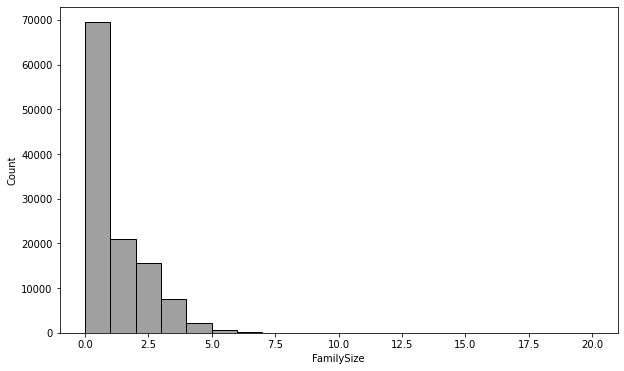

In [6]:
ax = sns.histplot(x = "FamilySize", data = train,binwidth=1,color='grey')
ax.figure.set_size_inches(10,6)
# set x labels

In [7]:
train['FamilySize'].value_counts()

0.0     69492
1.0     21074
2.0     15584
3.0      7645
4.0      2273
5.0       577
6.0       124
7.0        43
8.0        14
9.0         5
10.0        4
13.0        1
20.0        1
Name: FamilySize, dtype: int64

In [8]:
train['FamilySize'].median()

0.0

**Family** заполним 0, т.к. это медианное значение.

In [9]:
train['MonthlyIncome'].median()

5400.0

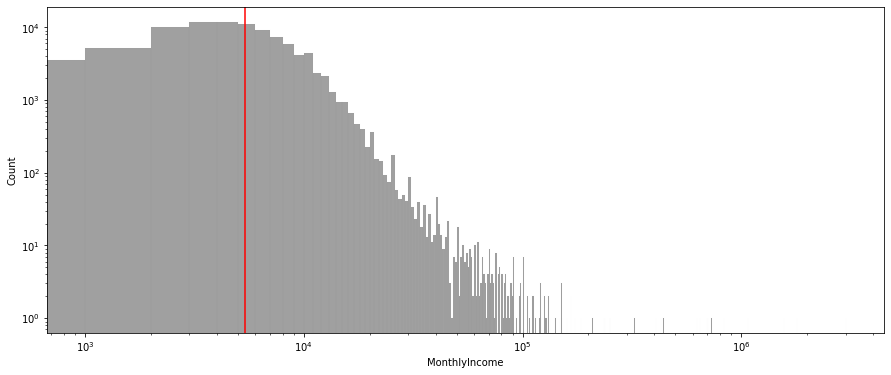

In [10]:
ax = sns.histplot(x = "MonthlyIncome", data = train,binwidth=1000,color='grey')
ax.set_xscale('log')
ax.set_yscale('log')
plt.axvline(train['MonthlyIncome'].median(),color='red')#покажем медианное значение
ax.figure.set_size_inches(15,6)

**MonthlyIncome** заполним 5400 (медианное значение).

In [11]:
train_complete =  train.fillna(value={'FamilySize':'0','MonthlyIncome':5400})

In [12]:
train_complete.isna().sum()

Unnamed: 0                        0
Age                               0
FamilySize                        0
PastDueLess_60                    0
PastDue60_90                      0
PastDue90_More                    0
DebtRatio                         0
MonthlyIncome                     0
TotalBalanceDivideCreditLimits    0
OpenLoans                         0
RealEstateLoans                   0
Target                            0
dtype: int64

In [13]:
train_complete.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120000.0,59999.500000,34641.160489,0.0,29999.750000,59999.500000,89999.250000,119999.0
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.0
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.0
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.0
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,120000.0,354.325463,2202.059099,0.0,0.174872,0.366284,0.868460,329664.0
MonthlyIncome,120000.0,6423.863533,13858.143132,0.0,3900.000000,5400.000000,7397.000000,3008750.0
TotalBalanceDivideCreditLimits,120000.0,6.087314,260.236593,0.0,0.029988,0.154325,0.561243,50708.0
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.0
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.0


<a id='graphs'></a>
## Графики

### Описание столбцов

**Target |** Заемщик имел просрочку платежа на 90 дней или хуже (1 - имел, 0 - не имел)

**Age |** Возраст замещика (целое число)

**FamilySize |** Количество иждивенцев в семье заёмщика, исключая самого заёмщика (супруг, дети и т. д.) (целое число)

**PastDueLess_60 |** Сколько раз заемщик просрочивал платеж на 30-59 дней, но не более того за последние 2 года  (целое число)

**PastDue60_90 |** Сколько раз заемщик просрочивал платежи на 60-89 дней, но не более того за последние 2 года. (целое число)

**PastDue90_More |** Сколько раз заемщик просрочивал платеж на 90 дней и более (целое число)

**DebtRatio |**  Ежемесячные платежи по долгам, алименты, расходы на проживание, разделенные на ежемесячный доход (процент)

**MonthlyIncome |** Ежемесячный доход (число)

**TotalBalanceDivideCreditLimits |** Общий баланс по кредитным картам и личным кредитным линиям, за исключением недвижимости и без долгов в рассрочку, таких как автокредиты, разделенный на сумму кредитных лимитов (процент)

**OpenLoans |** Количество открытых кредитов (в рассрочку, таких как автокредит или ипотека) и кредитных линий (например, кредитные карты) (целое число)

**RealEstateLoans |** Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья (целое число)

Смотрим на распределения переменных как они есть.

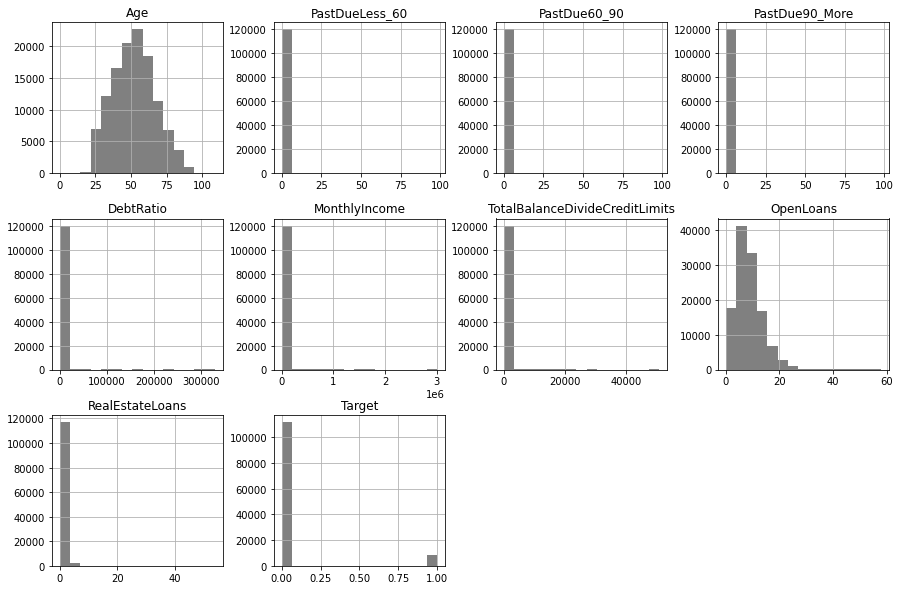

In [14]:
train_complete.iloc[:,1:12].hist(bins=15,figsize=(15,10),layout=(3,4),color='grey');

Как видно, многие данные имеют распределение, похожее на лог-нормальное, т.е. очень много маленьких значений и длинный хвост. Например PastDueLess_60 и т.п., или DebtRatio. Будем разбираться что с ними делать.

Смотрим на пропорцию в целевой переменной "Target" 1/0. Какая минимальная accuracy может быть? **93%**

In [15]:
((train_complete['Target'].value_counts()) / len(train_complete)*100).round(1)

0    93.3
1     6.7
Name: Target, dtype: float64

Смотрим на некоторые переменные, в особенности на те, которые подозреваются в выбросах.

In [16]:
train_complete_smpl1000 = train_complete.sample(1000)#sample 1000 for quick graphics

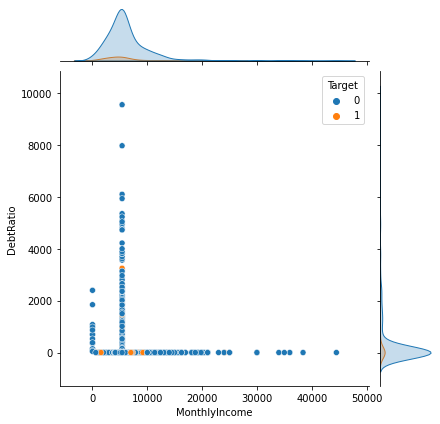

In [17]:
sns.jointplot(x=train_complete_smpl1000['MonthlyIncome'],
                y=train_complete_smpl1000['DebtRatio'],
                hue=train_complete_smpl1000['Target'])

plt.show()

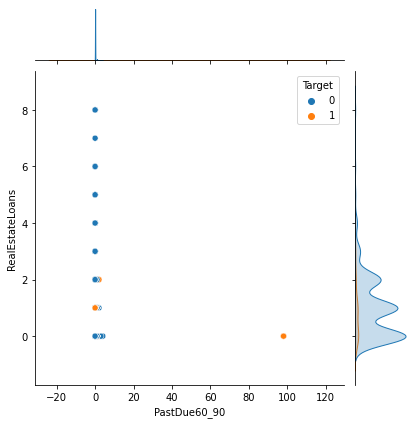

In [18]:
sns.jointplot(x=train_complete_smpl1000['PastDue60_90'],
                y=train_complete_smpl1000['RealEstateLoans'],
                hue=train_complete_smpl1000['Target'])
plt.show()

Проверяем как соотносятся Target и выбросы в PastDue60_90 и т.п..

In [19]:
train2 = train_complete[['PastDue60_90','PastDue90_More','PastDueLess_60','Target']] #фильтруем только "нужные" столбцы
train2[train2['PastDue90_More'] > 70].value_counts() # таких точек 111 и их надо как-то учесть!

PastDue60_90  PastDue90_More  PastDueLess_60  Target
98            98              98              1         114
                                              0          97
96            96              96              1           4
                                              0           1
dtype: int64

Переменная **Target** имеет 0 и 1 для высоких значений **PastDue...**, значит нужно их оставить и выделить в отдельный класс. 
Очень странно выходит, что если в колонке **PastDue90_More** есть положительное значение (например 96 или 98) как при этом можеть быть что в  **Target** значение 0 (не имел задолженности)?
Сделаем доп переменную для высоких значений **PastDue90_More**

Посмотрим на распределение кредитов в числах.

In [20]:
train_complete.groupby('RealEstateLoans').count()['Unnamed: 0']

RealEstateLoans
0     45070
1     41739
2     25226
3      5081
4      1718
5       548
6       252
7       128
8        71
9        63
10       24
11       21
12       16
13       11
14        5
15        7
16        3
17        3
18        2
19        2
20        2
21        1
23        2
25        2
29        1
32        1
54        1
Name: Unnamed: 0, dtype: int64

И в графиках.

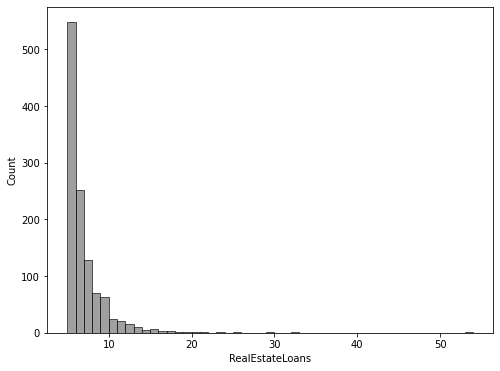

In [21]:
ax = sns.histplot(x = "RealEstateLoans", 
                  data = train_complete[train_complete['RealEstateLoans'] >4],
                  binwidth=1,
                  color='grey')
ax.figure.set_size_inches(8,6)

Смотрим на кроссплот после фильтрации аномально высоких значений в колонке **PastDue**.

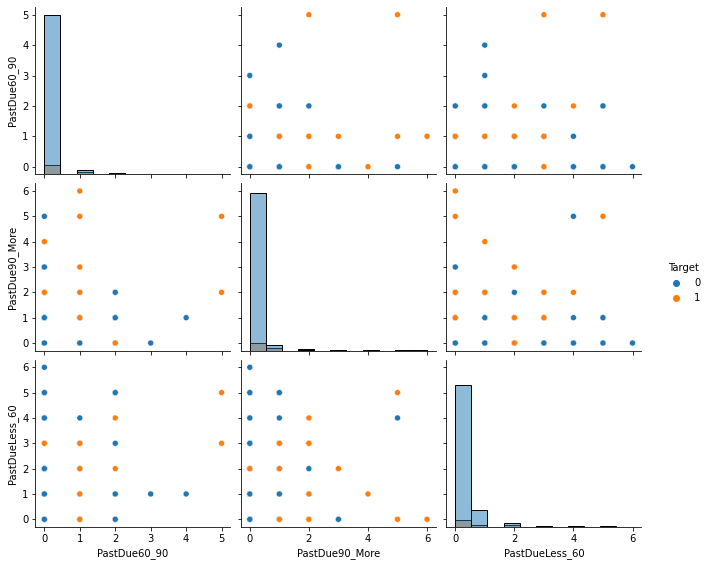

In [22]:
ax = sns.pairplot(train2[train2['PastDue60_90'] < 96 ].sample(1000),hue="Target",diag_kind = "hist")
ax.figure.set_size_inches(10,8)

Стало лучше, но как-то не похоже что эти параметры определяют целевую переменную.

### Переменные с логнормальным распределением

Посмотрим на переменные у которых "длинный хвост" и как они могут разделить или нет переменную Target.

In [23]:
#напишем функцию которая строит нам боксплоты

def boxplot_target (y):
    sns.set(font_scale = 1.1,style="whitegrid")
    f,ax = plt.subplots(figsize=(15, 8))

    ax.set_yscale("log") #лог преобразование шкалы

    sns.stripplot(y=y,
                  x='Target',
                  data=train_complete_smpl1000,
                  size = 4, 
                  alpha=0.4)
    sns.boxplot(y = y,
                data = train_complete_smpl1000,
                width = 0.5,
                x='Target',
                boxprops=dict(alpha=0.3))

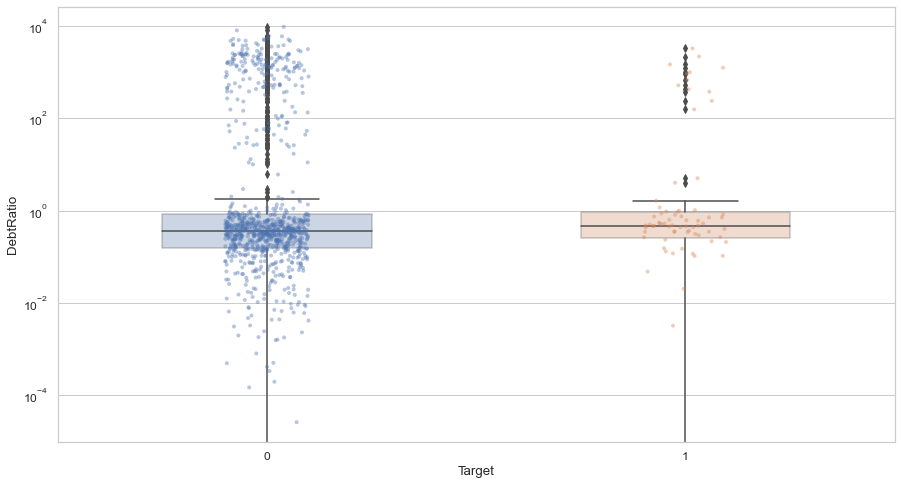

In [24]:
boxplot_target('DebtRatio')

Как и следовало ожидать, есть выбросы - аномально большие отношения кредитов к доходу, но поскольку это не единичные случаи, то оставим их, просто в дальнейшем сделаем лог преобразование переменных.

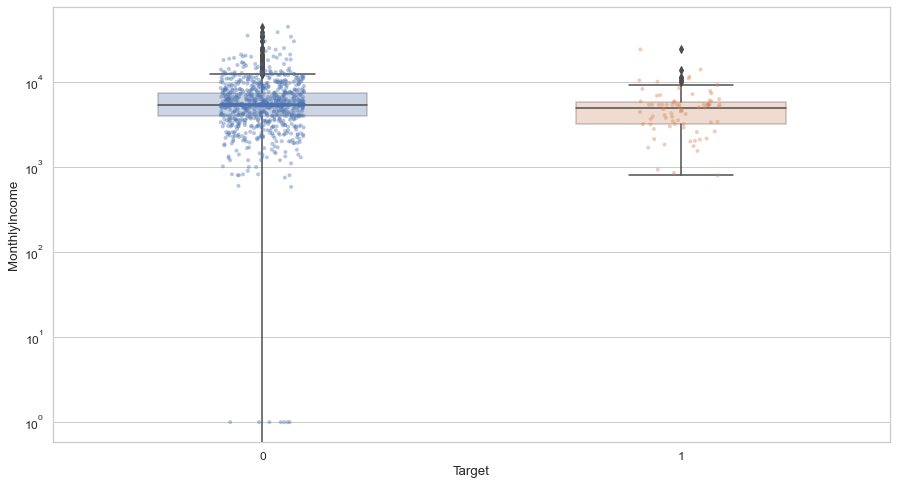

In [25]:
boxplot_target('MonthlyIncome')

Есть выбросы как в минимальную, так и в максимальную сторону, но в целом для 0 и 1 распределение очень похожее.

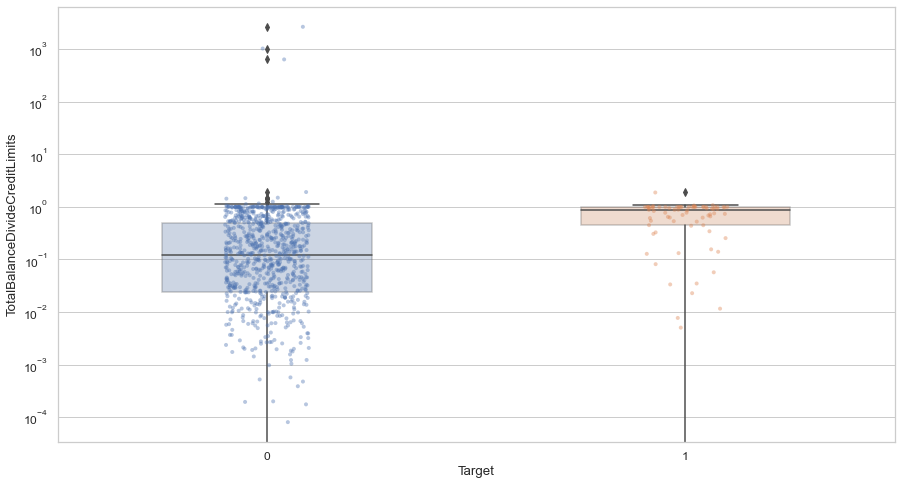

In [26]:
boxplot_target('TotalBalanceDivideCreditLimits')

Вот эта переменная, похоже, что имеет неплохую связь с нашей целевой переменной, медианы и распределения отстоят друг от друга.

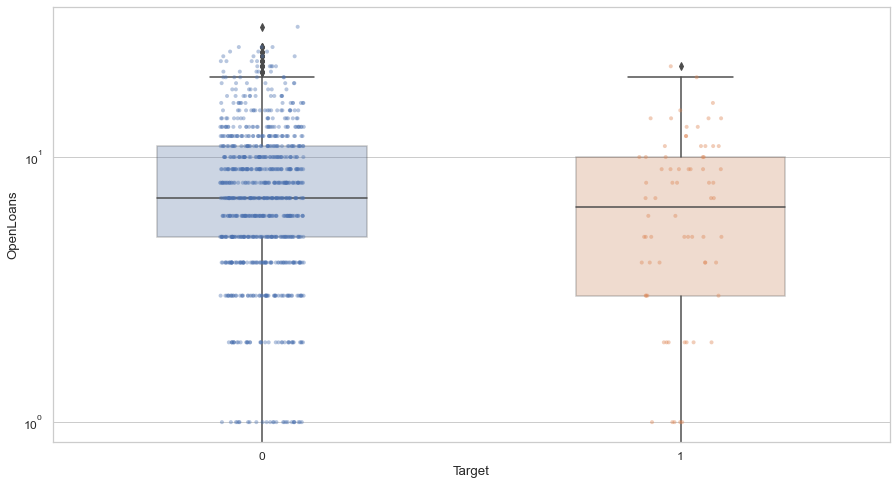

In [27]:
boxplot_target('OpenLoans')

**Выводы**

Создаем отдельную переменную где:
*   PastDueLess_60 >= 96
*   PastDue60_90 >= 96
*   PastDue90_More >= 96
и отдельную где
*   RealEstateLoans >= 14

Почему >= 14? Потому что после 14 значений реально мало <10.

Эти переменные преобразовываем логарифмом:
*   DebtRatio
*   MonthlyIncome
*   TotalBalanceDivideCreditLimits

<a id='data_proc'></a>
## Обработка данных

In [28]:
train_proc = train_complete.copy()

In [29]:
train_proc['high_past_due'] = np.where(train_proc['PastDue60_90'] >= 96, 1,0)
train_proc['high_loans'] = np.where(train_proc['RealEstateLoans'] >= 14, 1,0)

In [30]:
# проверяем выборочные значения, как сработало создание переменной
train_proc.loc[(train_proc['PastDue60_90'] < 95) & 
                   (train_proc['RealEstateLoans'] > 30), 
                   ['PastDue60_90','RealEstateLoans','high_past_due','high_loans']].head()

,PastDue60_90,RealEstateLoans,high_past_due,high_loans
37354,0,32,0,1
93850,0,54,0,1


In [31]:
logcolumns = ['DebtRatio','MonthlyIncome','TotalBalanceDivideCreditLimits']
train_proc.loc[:, ('DebtRatio','MonthlyIncome','TotalBalanceDivideCreditLimits')] = np.log1p(train_proc[logcolumns])

Смотрим что получилось

In [32]:
train_proc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120000.0,59999.500000,34641.160489,0.0,29999.750000,59999.500000,89999.250000,119999.000000
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000


Как видно из таблицы лог преобразовние сработало, максимумы в DebtRatio стали другими и добавились пару столбцов с новыми переменными: high_past_due, high_loans

In [33]:
train_proc.shape#double check size :)

(120000, 14)

Смотрим на графики после преобразований.

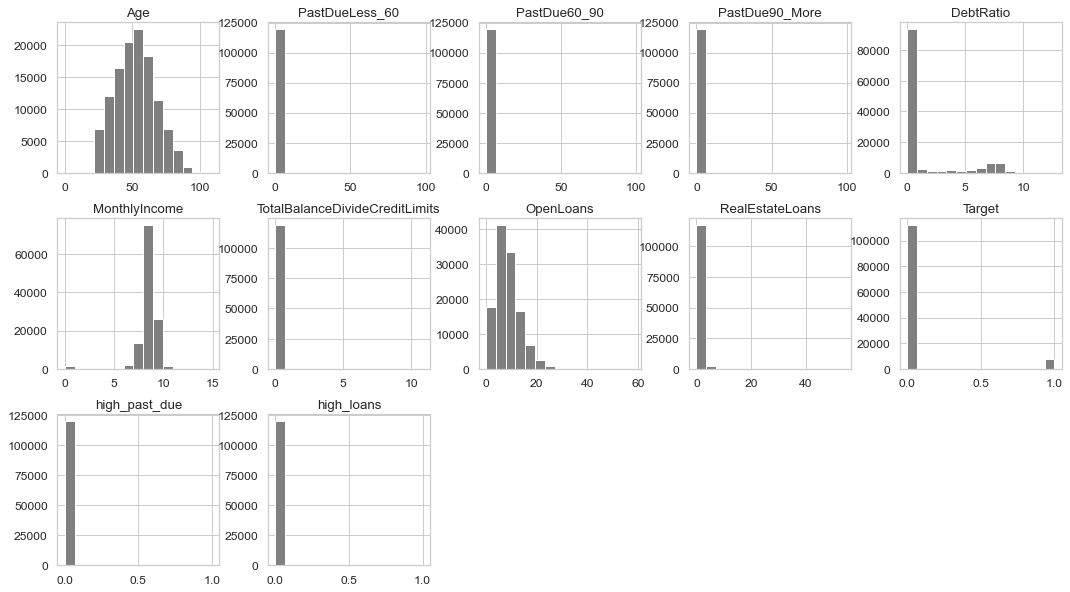

In [34]:
train_proc.iloc[:,1:14].hist(bins=15,figsize=(18,10),layout=(3,5),color='grey');


Отбираем 1000 точек, для ускорения графиков.

In [35]:
train_sample_1000 = train_proc.iloc[:,1:12].sample(1000)

Проверяем что соотношение целевой переменной такое-же в выборке.

In [36]:
((train_proc['Target'].value_counts()) / len(train_proc)*100).round(1)

0    93.3
1     6.7
Name: Target, dtype: float64

In [37]:
(train_sample_1000['Target'].value_counts()) / len(train_sample_1000)*100

0    93.2
1     6.8
Name: Target, dtype: float64

Считаем корреляцию между всеми параметрами и целевой переменной.

In [38]:
corr = train_proc.iloc[:,1:12].corr()

[Text(0.5, 1.0, 'Корреляция между параметрами')]

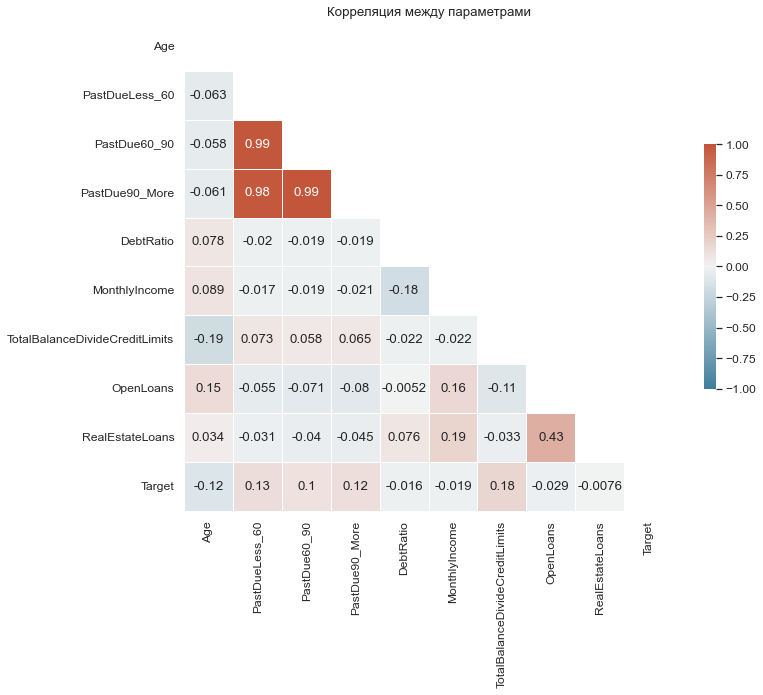

In [39]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot = True)
ax.set(title = "Корреляция между параметрами")
#symmetric colorbar

С линейной корреляцией не очень, единственные признаки, которые имеют сильную корреляцию между собой  - просроченные кредитные дни.(**PastDue**)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


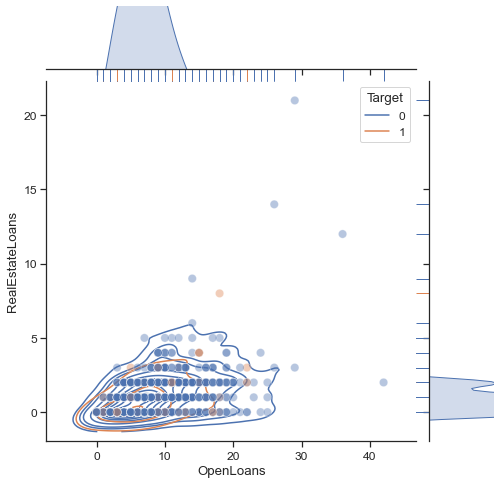

In [40]:
sns.set(font_scale = 1.1,style="ticks")

ax = sns.jointplot(y="RealEstateLoans",
                   x="OpenLoans",
                   hue='Target',
                   data=train_proc.sample(1000,random_state=1),
                   height = 1, 
                   alpha=0.4,
                  s=70)
ax.plot_joint(sns.kdeplot,zorder=0)
ax.plot_marginals(sns.rugplot,height=-0.2,clip_on=False)
ax.figure.set_size_inches(8,8)

Ради интереса можно посмотреть на зависимость между **OpenLoans** и **RealEstateLoans**, ну такое... скорее она возникает из-за нескольких аномальных точек где большие RealEstateLoans

<a id='data_split'></a>
## Разделение на выборки

In [41]:
fin_data = train_proc.drop('Unnamed: 0', axis=1) #   выкидываем первую колонку, индекс
fin_data.columns #проверяем что осталось

Index(['Age', 'FamilySize', 'PastDueLess_60', 'PastDue60_90', 'PastDue90_More',
       'DebtRatio', 'MonthlyIncome', 'TotalBalanceDivideCreditLimits',
       'OpenLoans', 'RealEstateLoans', 'Target', 'high_past_due',
       'high_loans'],
      dtype='object')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(fin_data.drop('Target', axis=1), fin_data['Target'], test_size=0.25, random_state=13)
X_train.shape, X_test.shape

((90000, 12), (30000, 12))

Пропорция в обучающей выборке.

In [43]:
zeros = len(y_train[y_train==0])
ones = len(y_train[y_train==1])
train_len = len(y_train)
zeros_ratio = (zeros/train_len)
ones_ratio = (ones/train_len)
print("zeros: ",round(zeros_ratio,2) , "\nones: ", round(ones_ratio,2))

zeros:  0.93 
ones:  0.07


In [44]:
X_train.head()

,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,high_past_due,high_loans
99296,48,2.0,0,0,0,0.281340,8.131825,0.110783,13,1,0,0
55478,33,0.0,0,0,0,0.358313,8.517393,0.063130,8,1,0,0
105148,66,0.0,0,0,0,0.039950,8.268988,0.074387,8,0,0,0
85985,68,0.0,0,0,0,0.069492,8.900685,0.047311,14,0,0,0
83514,68,0.0,0,0,0,0.455541,7.023759,0.613945,3,0,0,0


<a id='models'></a>
## Модели  

### Масштабируем данные

In [45]:
my_columns = X_train.columns

In [46]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [47]:
df = pd.DataFrame(X_train_sc, columns = my_columns )# возвращаю numpy обратно в dataframe чтобы статистику посмотреть

In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,90000.0,0.355749,0.167774,0.0,0.227273,0.352273,0.477273,1.0
FamilySize,90000.0,0.036777,0.055283,0.0,0.000000,0.000000,0.050000,1.0
PastDueLess_60,90000.0,0.004333,0.042614,0.0,0.000000,0.000000,0.000000,1.0
PastDue60_90,90000.0,0.002444,0.042214,0.0,0.000000,0.000000,0.000000,1.0
PastDue90_More,90000.0,0.002705,0.042360,0.0,0.000000,0.000000,0.000000,1.0
DebtRatio,90000.0,0.119939,0.207242,0.0,0.012755,0.024649,0.049103,1.0
MonthlyIncome,90000.0,0.566335,0.079910,0.0,0.554332,0.576143,0.597261,1.0
TotalBalanceDivideCreditLimits,90000.0,0.023779,0.035662,0.0,0.002721,0.013155,0.041022,1.0
OpenLoans,90000.0,0.145813,0.088721,0.0,0.086207,0.137931,0.189655,1.0
RealEstateLoans,90000.0,0.018859,0.021090,0.0,0.000000,0.018519,0.037037,1.0


### KNN
Считаем KNN c параметрами по умолчанию.

In [73]:
knncl = KNeighborsClassifier()
knncl.fit(X_train_sc,y_train)
y_knn_prob = knncl.predict_proba(X_test_sc)
y_knn_prob_1 = y_knn_prob[:,1]
knn_auc = roc_auc_score(y_test,y_knn_prob_1)
print(knn_auc)

0.648971724801615


### Линейный классификатор

In [74]:
# np.count_nonzero(np.isnan(X_train_sc)) #проверка нулевых значений

0

In [75]:
sgdclass = SGDClassifier(loss = 'log',learning_rate='constant',random_state=13,alpha=0,eta0=0.1,max_iter=1000)
sgdclass.fit(X_train_sc,y_train)
y_pred_prob = sgdclass.predict_proba(X_test_sc)
y_pred_prob_plus = y_pred_prob[:,1]# берем второй столбец, предсказывает вероятность 1
sgd_auc = roc_auc_score(y_test,y_pred_prob_plus)
print(sgd_auc)

0.7811164617333587


AUC получился лучше в линейном классификаторе, чем в КNN.

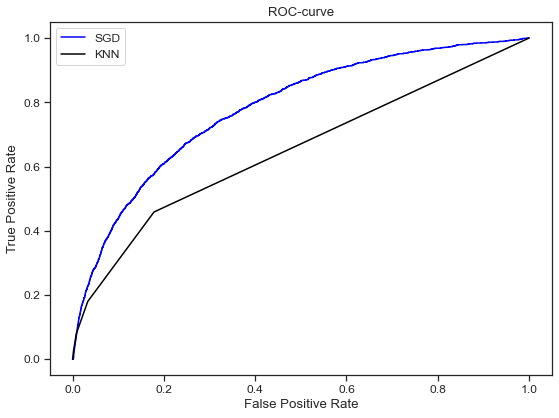

In [76]:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_plus)
    fpr_knn,tpr_knn,thresholds = roc_curve(y_test,y_knn_prob_1)
    plt.figure(figsize=(9, 6.5))
    plt.plot(fpr, tpr,color='blue',label='SGD')
    plt.plot(fpr_knn, tpr_knn,color='black',label='KNN')
    plt.title('ROC-curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

###  Линейный классификатор с перебором параметров


c:\users\ilya1\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


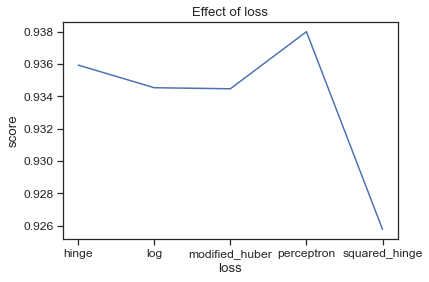

In [77]:
# losses
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    model = SGDClassifier(loss=loss, penalty="l2", max_iter=1000,random_state=13)
    model.fit(X_train_sc, y_train)
    scores.append(model.score(X_test_sc, y_test))

plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

Оказывается лучшая функция [perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)  но нам нужна вероятность, поэтому возьмем modified_huber.  

Пишем функции чтобы тренировать модели и записывать AUC.

In [49]:
def train_best_model(model,X_train,y_train,X_test,y_test,params):
    clf = GridSearchCV(model, param_grid=params,scoring='roc_auc',cv=3)# set scoring to AUC, CV=3
    clf.fit(X_train,y_train)
    output = clf.best_estimator_
    return output

def save_auc(model,X_test,y_test):
    prob = model.predict_proba(X_test)
    prob_1 = prob[:,1]#probability of class 1
    auc = roc_auc_score(y_test,prob_1)
    return auc

def elements_roc_curve(model,X_test,y_test):
    prob = model.predict_proba(X_test)
    prob_1 = prob[:,1]#probability of class 1
    fpr,tpr,thresholds = roc_curve(y_test,prob_1)
    return fpr,tpr,thresholds

Тренируем модель и смотрим AUC.

In [79]:
# parameters for linear classifier
parameters = {
    "loss" : ["modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]
}

model = SGDClassifier(max_iter=1000,random_state=13)

In [80]:
sgd_best = train_best_model(model,X_train_sc,y_train,X_test_sc,y_test,parameters)
sgd_best_auc = save_auc(sgd_best,X_test_sc,y_test)
sgd_best_auc

0.838141096604731

In [81]:
fpr_sgd,tpr_sgd,thresholds_sgd = elements_roc_curve(sgd_best,X_test_sc,y_test)

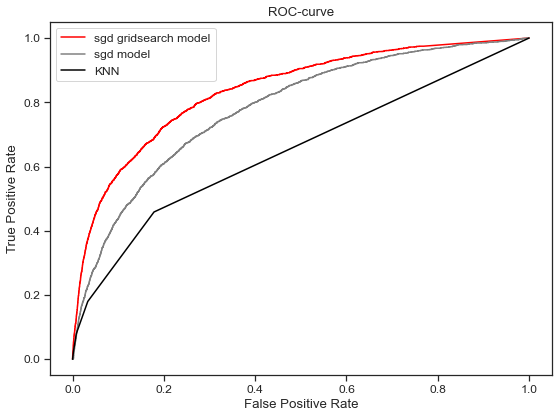

In [82]:
plt.figure(figsize=(9, 6.5))
plt.plot(fpr_sgd, tpr_sgd,color='red',label = 'sgd gridsearch model')
plt.plot(fpr, tpr,color='grey',label='sgd model')
plt.plot(fpr_knn, tpr_knn,color='black',label='KNN')
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Прогресс на лицо, модель с перебором параметров выдает AUC лучше.

### Random Forest

In [83]:
parameters_rf = {
    "max_depth" : [3,4],
    "n_estimators" : [50,100]
}

model_rf = RandomForestClassifier(random_state=13)

In [84]:
rf_best = train_best_model(model_rf,X_train_sc,y_train,X_test_sc,y_test,parameters_rf)
rf_best_auc = save_auc(rf_best,X_test_sc,y_test)
rf_best_auc

0.8596879175442718

In [85]:
dump(rf_best,'rf_best.joblib') # saving model

['rf_best.joblib']

In [62]:
# rf_best = load('rf_best.joblib') 

In [86]:
fpr_rf,tpr_rf,thresholds_rf = elements_roc_curve(rf_best,X_test_sc,y_test)

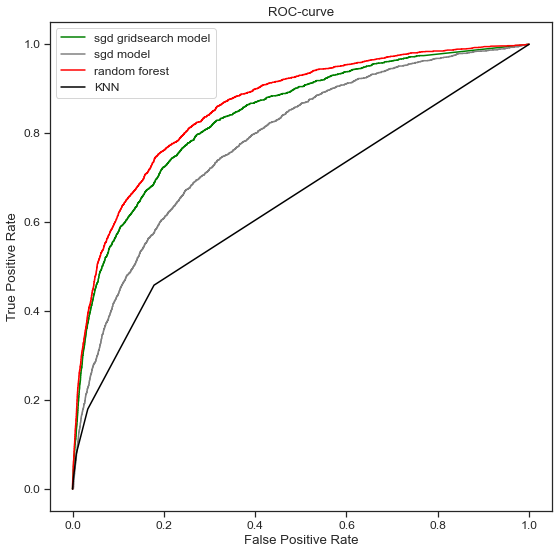

In [87]:
plt.figure(figsize=(9, 9))
plt.plot(fpr_sgd, tpr_sgd,color='green',label = 'sgd gridsearch model')
plt.plot(fpr, tpr,color='grey',label='sgd model')
plt.plot(fpr_rf, tpr_rf,color='red',label='random forest')
plt.plot(fpr_knn, tpr_knn,color='black',label='KNN')
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Random Forest, как и следовало ожидать, выдает модель еще лучше.

### GradientBoosting

In [190]:
parameters_gb = {
    "max_depth" : [4,7],
    "n_estimators" : [50,80],
    "learning_rate" : [0.05,0.1,0.2]
}

model = GradientBoostingClassifier(random_state=13)

In [191]:
gb_best = train_best_model(model,X_train_sc,y_train,X_test_sc,y_test,parameters_gb)

In [91]:
gb_best_auc = save_auc(gb_best,X_test_sc,y_test)
gb_best_auc

0.8571795418523942

In [193]:
dump(gb_best,'grad_boos.joblib') # save model gradient boosting

['grad_boos.joblib']

In [88]:
# gb_best = load('grad_boos.joblib')

In [89]:
fpr_gb,tpr_gb,thresholds_gb = elements_roc_curve(gb_best,X_test_sc,y_test)

<a id="final_auc"></a>

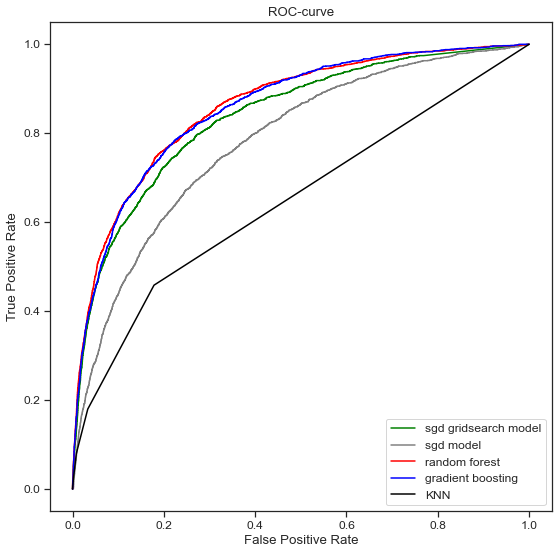

In [90]:
plt.figure(figsize=(9, 9))
plt.plot(fpr_sgd, tpr_sgd,color='green',label = 'sgd gridsearch model')
plt.plot(fpr, tpr,color='grey',label='sgd model')
plt.plot(fpr_rf, tpr_rf,color='red',label='random forest')
plt.plot(fpr_gb, tpr_gb,color='blue',label = 'gradient boosting')
plt.plot(fpr_knn, tpr_knn,color='black',label='KNN')
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Gradient Boosting не дал какого-то преимущества...

<a id='new_features'></a>
## Создание новых признаков
C помощью К-среднего я сделал новый признак из трех наиболее странных колонок данных.


In [51]:
X_clust = fin_data[['PastDueLess_60','PastDue60_90','PastDue90_More']]
X_clust.shape

(120000, 3)

In [52]:
km = KMeans(n_clusters=5, random_state = 13)    
km.fit(X_clust)
X_clust.loc[:,'km'] = km.labels_


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [53]:
X_clust['km'].value_counts()

0    99726
2    15568
3     2445
4     2045
1      216
Name: km, dtype: int64

В принципе, еще до этого мы сделали один кластер, когда создали колонку где этот параметр очень большой (> 96), тут же мы сделали пять кластеров.

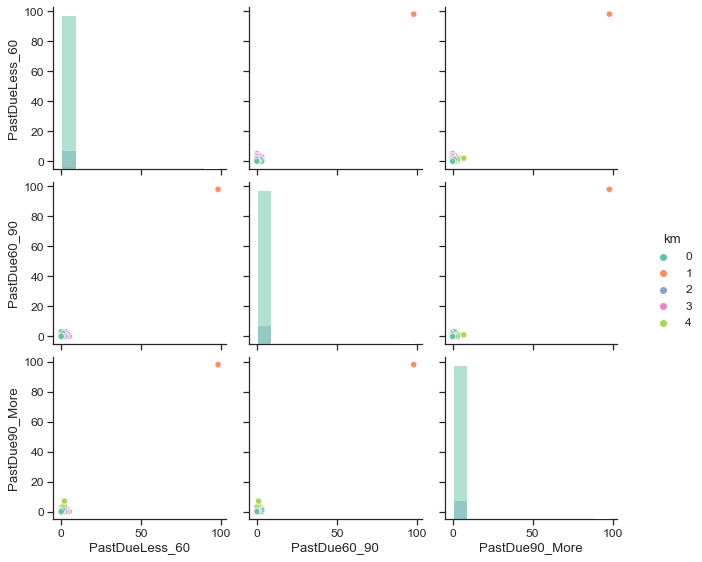

In [95]:
# sns.color_palette("hls", 8)
plot_kws = {"s":4}
ax = sns.pairplot(X_clust.sample(1000),hue="km",palette = "Set2", diag_kind = "hist")
ax.figure.set_size_inches(10,8)

C:\Users\ilya1\AppData\Local\Temp\ipykernel_3252\3003714647.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data=X_clust.sample(1000)[X_clust['PastDueLess_60'] < 90],


<AxesSubplot:xlabel='PastDueLess_60', ylabel='Count'>

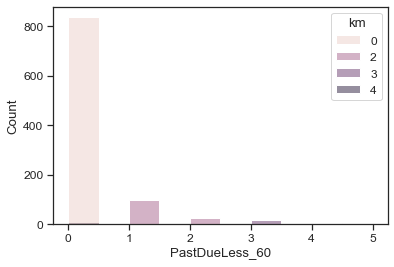

In [96]:
sns.set_palette("pastel")
sns.histplot(data=X_clust.sample(1000)[X_clust['PastDueLess_60'] < 90],
             x="PastDueLess_60",
             hue='km',
             bins=10)

Видно что большинство находится в кластере 0, остальные представлены сильно меньше, но посмотрим, вдруг даже это поможет.

In [54]:
fin_data_nf = fin_data.copy() #nf - new feature
fin_data_nf['km'] = km.labels_ #add column with clusters

In [55]:
fin_data_nf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000
Target,120000.0,0.066842,0.249749,0.0,0.000000,0.000000,0.000000,1.000000


In [56]:
X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(fin_data_nf.drop('Target', axis=1), fin_data_nf['Target'], test_size=0.25, random_state=13)
X_train_nf.shape, X_test_nf.shape

((90000, 13), (30000, 13))

In [57]:
scaler = MinMaxScaler()
X_train_nf_sc = scaler.fit_transform(X_train_nf)
X_test_nf_sc = scaler.fit_transform(X_test_nf)

In [58]:
df = pd.DataFrame(X_train_nf_sc)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,90000.0,0.355749,0.167774,0.0,0.227273,0.352273,0.477273,1.0
1,90000.0,0.036777,0.055283,0.0,0.000000,0.000000,0.050000,1.0
2,90000.0,0.004333,0.042614,0.0,0.000000,0.000000,0.000000,1.0
3,90000.0,0.002444,0.042214,0.0,0.000000,0.000000,0.000000,1.0
4,90000.0,0.002705,0.042360,0.0,0.000000,0.000000,0.000000,1.0
5,90000.0,0.119939,0.207242,0.0,0.012755,0.024649,0.049103,1.0
6,90000.0,0.566335,0.079910,0.0,0.554332,0.576143,0.597261,1.0
7,90000.0,0.023779,0.035662,0.0,0.002721,0.013155,0.041022,1.0
8,90000.0,0.145813,0.088721,0.0,0.086207,0.137931,0.189655,1.0
9,90000.0,0.018859,0.021090,0.0,0.000000,0.018519,0.037037,1.0


Добавим кластер как новый признак и попробуем random forest.

In [102]:
parameters_rf = {
    "max_depth" : [3,4],
    "n_estimators" : [50,100]
}

model_rf = RandomForestClassifier(random_state=13)

In [103]:
rf_nf_best = train_best_model(model_rf,X_train_nf_sc,y_train,X_test_nf_sc,y_test,parameters_rf)

In [104]:
rf_nf_best_auc = save_auc(rf_nf_best,X_test_nf_sc,y_test)
rf_nf_best_auc

0.8586785359696387

In [105]:
dump(rf_nf_best,'rf_nf_best.joblib') # save model random forest with new feature

['rf_nf_best.joblib']

In [210]:
# gb_nf_best = load('gb_nf_best.joblib')

Странно, но random forest что с новым признаком, что без него дал одинаковый AUC.

In [106]:
fpr_rf_nf,tpr_rf_nf,thresholds_rf_nf = elements_roc_curve(rf_nf_best,X_test_nf_sc,y_test)

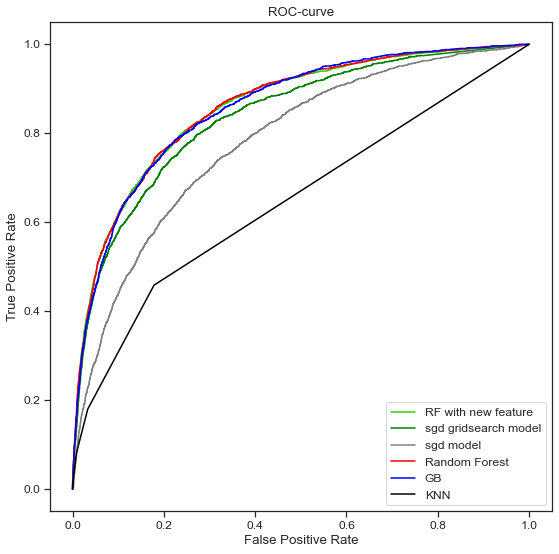

In [107]:
plt.figure(figsize=(9, 9))
plt.plot(fpr_rf_nf,tpr_rf_nf,color='#33cc00',label = 'RF with new feature')
plt.plot(fpr_sgd, tpr_sgd,color='green',label = 'sgd gridsearch model')
plt.plot(fpr, tpr,color='grey',label='sgd model')
plt.plot(fpr_rf, tpr_rf,color='red',label='Random Forest')
plt.plot(fpr_gb, tpr_gb,color='blue',label = 'GB')
plt.plot(fpr_knn, tpr_knn,color='black',label = 'KNN')
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [108]:
ideal_cutof = thresholds_rf_nf[np.argmin(abs(tpr_rf_nf-(1-fpr_rf_nf)))]#ради интереса ищем идеальный порог отсечения вероятности
print(ideal_cutof)

0.07136869336755768


In [109]:
df_cutoffs = pd.DataFrame(fpr_rf_nf,columns=['FPR'])
df_cutoffs['TPR'] = tpr_rf_nf
df_cutoffs['cutof'] = thresholds_rf_nf
df_cutoffs[df_cutoffs['cutof'] == ideal_cutof]

,FPR,TPR,cutof
2675,0.2209,0.779106,0.071369


In [110]:
d = {'auc': [knn_auc,sgd_auc,sgd_best_auc, rf_best_auc, gb_best_auc, rf_nf_best_auc],
                      'models': ['KNN','Linear','Linear Greadsearch','Random Forest','Grad Boost','RF with new feature']}
auc_df = pd.DataFrame(data=d)
auc_df['auc'] = pd.to_numeric(auc_df['auc'])  
auc_df = auc_df.sort_values(['auc'])
auc_df

,auc,models
0,0.648972,KNN
1,0.781116,Linear
2,0.838141,Linear Greadsearch
4,0.857180,Grad Boost
5,0.858679,RF with new feature
3,0.859688,Random Forest


In [111]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",color='white')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

<a id="AUC_comparison"></a>

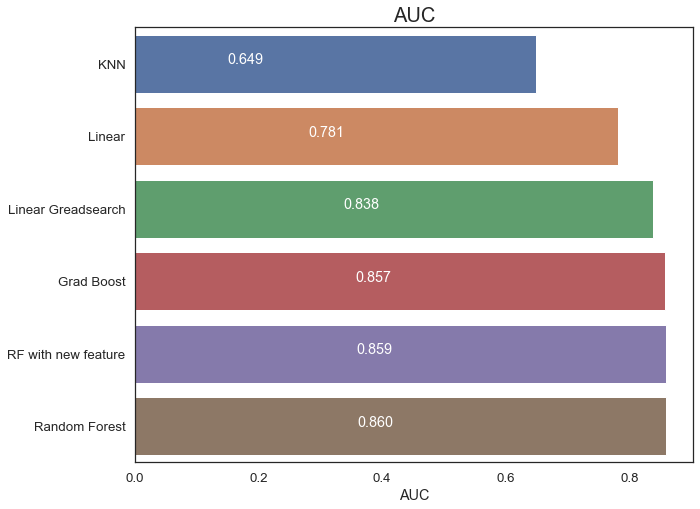

In [112]:
sns.set(font_scale = 1.2,style="white")
ax = sns.barplot(y='models',x='auc',data=auc_df)
ax.figure.set_size_inches(10,8)
plt.xlabel('AUC')
plt.ylabel('')
plt.title("AUC", fontsize=20)
show_values(ax,"h",space=-0.5)

Новый признак не дал особенного преимущества. Можно и без него использовать random forest, который дает лучший результат.

<a id="mean"></a>
## Осреднение, тренировка на всей выборке

Берем вероятности из двух лучших предсказаний, осредняем и считаем новый AUC.


In [113]:
# random forest with new feature
rf_nf_prob = rf_nf_best.predict_proba(X_test_nf_sc)
rf_nf_prob_1 = rf_nf_prob[:,1]#probability of class 1

# random forest
rf_prob = rf_best.predict_proba(X_test_sc)
rf_prob_1 = rf_prob[:,1]#probability of class 1

# calculate mean value
mean = (rf_nf_prob_1+rf_prob_1)/2
average_auc = roc_auc_score(y_test,mean)
print(average_auc)

0.8599202465449438


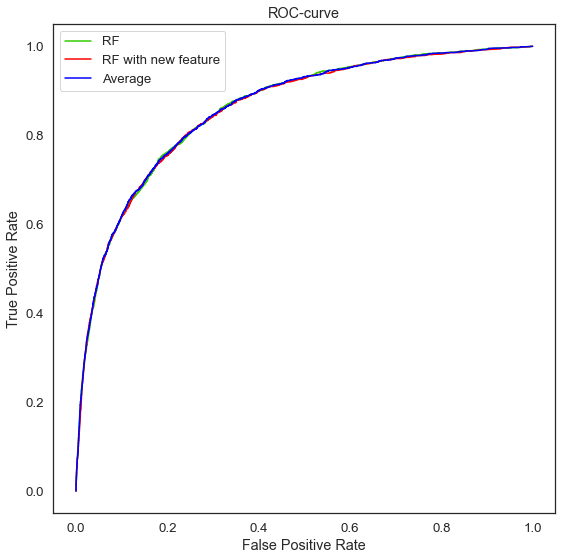

In [114]:
fpr_mean, tpr_mean, thresholds = roc_curve(y_test, mean)
plt.figure(figsize=(9, 9))
plt.plot(fpr_rf,tpr_rf,color='#33cc00',label = 'RF')
plt.plot(fpr_rf_nf, tpr_rf_nf,color='red',label='RF with new feature')
plt.plot(fpr_mean, tpr_mean,color='blue',label = 'Average')
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Среднее двух моделей получилось неееемного лучше. Дисперсия среднего по двум случайным величинам (предсказаниям), при их не сильной коррелированности, может быть меньше.

<a id="submission"></a>
## Модель на всех данных
Берем лучшую модель *Random forest* и обучаем на всех данных.


In [115]:
fin_data.columns

Index(['Age', 'FamilySize', 'PastDueLess_60', 'PastDue60_90', 'PastDue90_More',
       'DebtRatio', 'MonthlyIncome', 'TotalBalanceDivideCreditLimits',
       'OpenLoans', 'RealEstateLoans', 'Target', 'high_past_due',
       'high_loans'],
      dtype='object')

In [116]:
fin_data.isna().sum()

Age                               0
FamilySize                        0
PastDueLess_60                    0
PastDue60_90                      0
PastDue90_More                    0
DebtRatio                         0
MonthlyIncome                     0
TotalBalanceDivideCreditLimits    0
OpenLoans                         0
RealEstateLoans                   0
Target                            0
high_past_due                     0
high_loans                        0
dtype: int64

In [117]:
fin_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000
Target,120000.0,0.066842,0.249749,0.0,0.000000,0.000000,0.000000,1.000000


In [118]:
fin_data_sc = scaler.fit_transform(fin_data.drop(['Target'],axis=1)) #масштабируем данные, выбрасываем таргет колонку

In [89]:
y_fin = fin_data['Target']

In [120]:
fin_data_sc.shape

(120000, 12)

In [121]:
Xtest.isna().sum()

Unnamed: 0                           0
Age                                  0
FamilySize                         761
PastDueLess_60                       0
PastDue60_90                         0
PastDue90_More                       0
DebtRatio                            0
MonthlyIncome                     6015
TotalBalanceDivideCreditLimits       0
OpenLoans                            0
RealEstateLoans                      0
dtype: int64

In [76]:
Xtest_fill =  Xtest.fillna(value={'FamilySize':'0','MonthlyIncome':5400}) #заполняем тест данные так-же как и до

In [77]:
Xtest_fill.isna().sum()

Unnamed: 0                        0
Age                               0
FamilySize                        0
PastDueLess_60                    0
PastDue60_90                      0
PastDue90_More                    0
DebtRatio                         0
MonthlyIncome                     0
TotalBalanceDivideCreditLimits    0
OpenLoans                         0
RealEstateLoans                   0
dtype: int64

In [78]:
Xtest_fill.columns

Index(['Unnamed: 0', 'Age', 'FamilySize', 'PastDueLess_60', 'PastDue60_90',
       'PastDue90_More', 'DebtRatio', 'MonthlyIncome',
       'TotalBalanceDivideCreditLimits', 'OpenLoans', 'RealEstateLoans'],
      dtype='object')

In [79]:
#создаем те же признаки что и на обучающихся данных
Xtest_proc = Xtest_fill.copy()
Xtest_proc['high_past_due'] = np.where(Xtest_proc['PastDue60_90'] >= 96, 1,0)
Xtest_proc['high_loans'] = np.where(Xtest_proc['RealEstateLoans'] >= 14, 1,0)

In [80]:
Xtest_proc.head()

,Unnamed: 0,Age,FamilySize,PastDueLess_60,PastDue60_90,PastDue90_More,DebtRatio,MonthlyIncome,TotalBalanceDivideCreditLimits,OpenLoans,RealEstateLoans,high_past_due,high_loans
0,0,29,0.0,0,0,0,0.507926,1450.0,0.342927,7,0,0,0
1,1,57,3.0,1,1,0,0.564293,6866.0,0.136791,17,3,0,0
2,2,54,2.0,0,0,0,182.500000,1.0,0.102878,4,1,0,0
3,3,70,0.0,0,0,0,0.645671,6143.0,0.920908,14,2,0,0
4,4,55,0,0,0,0,0.000000,5400.0,0.000000,1,0,0,0


fin_data - полная обучающая выборка, X_test_full - полная тренировочная

In [81]:
Xtest_proc_fin = Xtest_proc.copy()
Xtest_proc_fin = Xtest_proc_fin.drop('Unnamed: 0', axis=1)

In [128]:
Xtest_proc_fin.columns

Index(['Age', 'FamilySize', 'PastDueLess_60', 'PastDue60_90', 'PastDue90_More',
       'DebtRatio', 'MonthlyIncome', 'TotalBalanceDivideCreditLimits',
       'OpenLoans', 'RealEstateLoans', 'high_past_due', 'high_loans'],
      dtype='object')

In [129]:
Xtest_fin_sc = scaler.fit_transform(Xtest_proc_fin) #scale test data

In [131]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

In [132]:
 rf_best.fit(fin_data_sc, y_fin) #train model on full data

RandomForestClassifier(max_depth=4, random_state=13)

In [133]:
final_prob_test = rf_best.predict_proba(Xtest_fin_sc)# predict probability

In [134]:
a = final_prob_test[:,1]
df_proba = pd.DataFrame(a,columns=['prob'])
df_proba['Target'] = np.where(df_proba['prob'] > ideal_cutof,1,0)# просто ради интереса используем выбранный выше порог

Смотрим распределение полученных вероятностей, просто ради интереса.

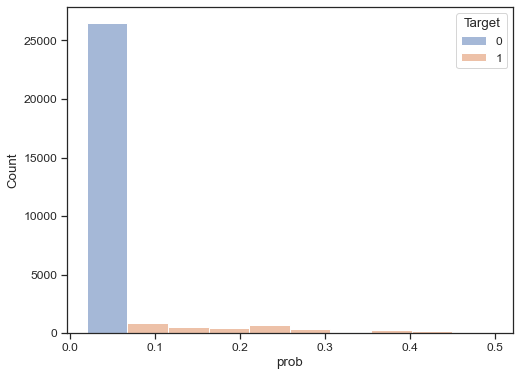

In [135]:
sns.set(font_scale = 1.1,style="ticks")
ax = sns.histplot(x = "prob", hue='Target',data = df_proba,bins=10)
ax.figure.set_size_inches(8,6)

In [136]:
((df_proba['Target'].value_counts()) / len(df_proba)*100).round(1)

0    88.4
1    11.6
Name: Target, dtype: float64

In [137]:
subm.head()


,Id,Target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [138]:
subm['Target'] = df_proba['prob']
subm.head()

,Id,Target
0,0,0.030090
1,1,0.163751
2,2,0.027570
3,3,0.028556
4,4,0.036469


In [243]:
subm.to_csv('2022-03-22_23_Ilya_Yulia.csv',sep=',',index=False)

### Осреднeние моделей

In [244]:
 gb_best.fit(fin_data_sc, y_fin) #train model on full data with gradient boosting

GradientBoostingClassifier(max_depth=4, n_estimators=80, random_state=13)

In [245]:
final_prob_test_gb = gb_best.predict_proba(Xtest_fin_sc)# predict probability
b = final_prob_test_gb[:,1]
mean = (a+b)/2
df_proba_mean = pd.DataFrame(mean,columns=['prob'])
subm['Target'] = df_proba_mean['prob']
subm.to_csv('2022-03-22_23_Ilya_Yulia_mean.csv',sep=',',index=False)

<a id="summary"></a>
# Вместо заключения

На самом деле, мне очень сильно мешало делать проект, то что я мои возможности (в питоне) сильно ограничены от моих желаний, а к большому сожалению, питон подтянуть в течение курса не вышло. Так уж вышло, что задания на программирования не дали никаких знаний, т.к. проверить их некому, в чём ошибки не понятно. Поэтому, по сути, как я умел программировать на питоне в начале (с помощью гугла), так и остался на этом же уровне. Но ведь у нас курс о машинном обучении, а не програмировании? С этой точки зрения модель у нас вышла вроде ничего.

По-хорошему надо было бы написать функцию, которая бы пробежалась по всем моделям, подсчитала AUC, записала бы в одну табличку и построить график, но на это, на самом деле тупо не хватило времени. На проект, по итогам было меньше чем две(?) недели, вместо месяца. Может это тоже бы помогло.

По-хорошему:
- Надо было бы взять все эти странные переменные (PastDue...) повозиться с ними и разбить не несколько категорий. То же самое можно было бы сделать с OpenLoans и RealEastateLoans. Одно это, судя по всему, может помочь с предсказанием.
- Возможно можно было бы ввести побольше классов для разных доходов.
- Возможно можно было бы построить модель предсказывающую MonthlyIncome, а не заполнять пробел медианным значением. 
- Может быть сделать модель для предсказания FamilySize (хотя тут может 0 и адекватная альтернатива).
- Ну а дальше, можно было бы взять Random Forest, xgboost, gradient boosting и как следует потренировать гиперпараметры особенно последних двух алгоритмов, с кросс-валидацией и всё такое.

Но уж вышло как вышло - индийский код, с элементами повтора и полная фрустрация от картинок (того какие они вышли). 

## P.S. Еще немного признаков
Ну и когда я это написал, то решил всё-таки попробовать добавить параметры и новый перебор random forest

In [59]:
fin_data_nf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000
Target,120000.0,0.066842,0.249749,0.0,0.000000,0.000000,0.000000,1.000000


In [60]:
fin_data_nf_clust = fin_data_nf[['OpenLoans','RealEstateLoans']]
km2 = KMeans(n_clusters=3, random_state = 13)    
km2.fit(fin_data_nf_clust)
fin_data_nf_clust.loc[:,'km2'] = km2.labels_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [61]:
fin_data_2xnf = fin_data_nf.copy() #nf - new feature
fin_data_2xnf['km2'] = km2.labels_ #add column with clusters
fin_data_2xnf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000
Target,120000.0,0.066842,0.249749,0.0,0.000000,0.000000,0.000000,1.000000


Можно взглянуть как выглядит новый признак относительно OpenLoans, например.

<AxesSubplot:xlabel='km2', ylabel='OpenLoans'>

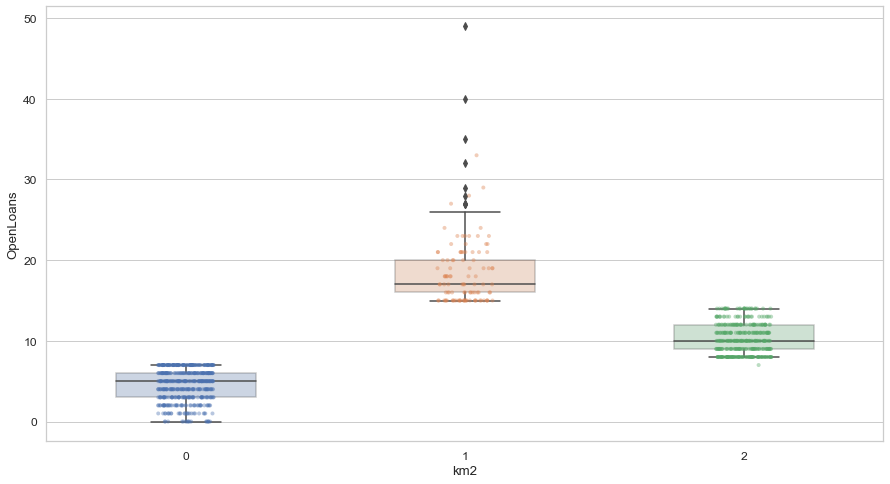

In [62]:
sns.set(font_scale = 1.1,style="whitegrid")
f,ax = plt.subplots(figsize=(15, 8))

# ax.set_yscale("log") #лог преобразование шкалы

sns.stripplot(y='OpenLoans',
                  x='km2',
                  data=fin_data_2xnf.sample(1000),
                  size = 4, 
                  alpha=0.4)

sns.boxplot(y = 'OpenLoans',
                data = fin_data_2xnf.sample(1000),
                width = 0.5,
                x='km2',
                boxprops=dict(alpha=0.3))

<AxesSubplot:xlabel='km2', ylabel='RealEstateLoans'>

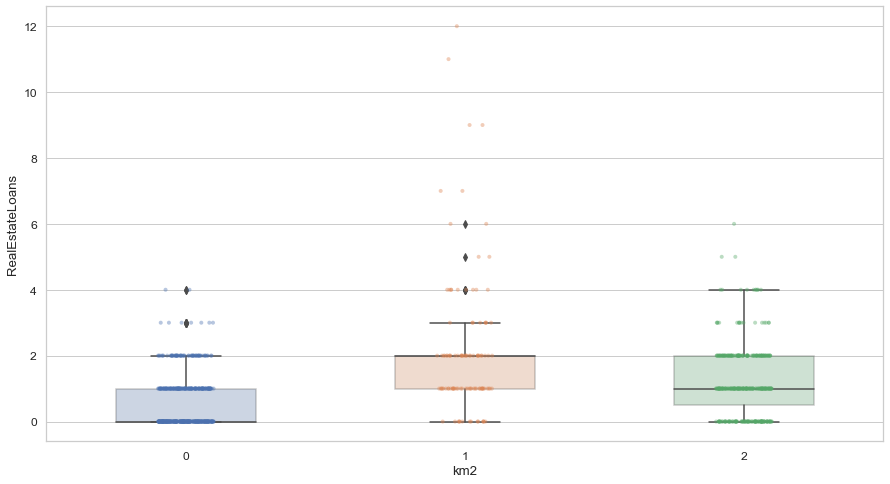

In [63]:
sns.set(font_scale = 1.1,style="whitegrid")
f,ax = plt.subplots(figsize=(15, 8))

# ax.set_yscale("log") #лог преобразование шкалы

sns.stripplot(y='RealEstateLoans',
                  x='km2',
                  data=fin_data_2xnf.sample(1000),
                  size = 4, 
                  alpha=0.4)

sns.boxplot(y = 'RealEstateLoans',
                data = fin_data_2xnf.sample(1000),
                width = 0.5,
                x='km2',
                boxprops=dict(alpha=0.3))

In [64]:
X_train_2xnf, X_test_2xnf, y_train_2xnf, y_test_2xnf = train_test_split(fin_data_2xnf.drop('Target', axis=1), fin_data_2xnf['Target'], test_size=0.25, random_state=13)
X_train_2xnf.shape, X_test_2xnf.shape

((90000, 14), (30000, 14))

In [66]:
scaler = StandardScaler()
X_train_2xnf_sc = scaler.fit_transform(X_train_2xnf)
X_test_2xnf_sc = scaler.fit_transform(X_test_2xnf)

In [67]:
parameters_rf_2xnf = {
    "max_depth" : [10,15],
    "n_estimators" : [100,150],
    "min_samples_split":[2,5,10],
    "max_features":['auto','sqrt']
}

model_rf_2xnf = RandomForestClassifier(random_state=13)

In [68]:
rf_2xnf_best = train_best_model(model_rf_2xnf,X_train_2xnf_sc,y_train,X_test_2xnf_sc,y_test,parameters_rf_2xnf)

In [69]:
rf_2xnf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

In [70]:
rf_2xnf_best_auc = save_auc(rf_2xnf_best,X_test_2xnf_sc,y_test)
rf_2xnf_best_auc

0.8671500381056585

In [71]:
dump(rf_2xnf_best,'rf_2xnf_best.joblib') # saving model

['rf_2xnf_best.joblib']

Применяем это всё ко всем данным.

In [72]:
fin_data_2xnf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,120000.0,52.278050,14.772080,0.0,41.000000,52.000000,63.000000,109.000000
PastDueLess_60,120000.0,0.424108,4.200864,0.0,0.000000,0.000000,0.000000,98.000000
PastDue60_90,120000.0,0.241200,4.162659,0.0,0.000000,0.000000,0.000000,98.000000
PastDue90_More,120000.0,0.267717,4.177488,0.0,0.000000,0.000000,0.000000,98.000000
DebtRatio,120000.0,1.522463,2.624331,0.0,0.161159,0.312095,0.625114,12.705832
MonthlyIncome,120000.0,8.445639,1.197561,0.0,8.268988,8.594339,8.908965,14.917036
TotalBalanceDivideCreditLimits,120000.0,0.258276,0.385867,0.0,0.029547,0.143516,0.445482,10.833859
OpenLoans,120000.0,8.441250,5.134965,0.0,5.000000,8.000000,11.000000,58.000000
RealEstateLoans,120000.0,1.016792,1.130938,0.0,0.000000,1.000000,2.000000,54.000000
Target,120000.0,0.066842,0.249749,0.0,0.000000,0.000000,0.000000,1.000000


In [73]:
fin_data_2xnf.shape

(120000, 15)

In [74]:
fin_data_2xnf_sc=scaler.fit_transform(fin_data_2xnf.drop(['Target'],axis=1))

Добавляем признаки к тестовым данным.

In [83]:
X_test_km1 = Xtest_proc_fin[['PastDueLess_60','PastDue60_90','PastDue90_More']]
km1 = KMeans(n_clusters=5, random_state = 13)    
km1.fit(X_test_km1)
X_test_km1.loc[:,'km1'] = km1.labels_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [84]:
X_test_km2 = Xtest_proc_fin[['OpenLoans','RealEstateLoans']]
km2 = KMeans(n_clusters=3, random_state = 13)    
km2.fit(X_test_km2)
X_test_km2.loc[:,'km2'] = km2.labels_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [85]:
Xtest_proc_fin_2xnf = Xtest_proc_fin.copy() #nf - new feature
Xtest_proc_fin_2xnf['km1'] = km1.labels_ #add column with clusters
Xtest_proc_fin_2xnf['km2'] = km2.labels_ #add column with clusters
Xtest_proc_fin_2xnf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,30000.0,52.363833,14.771055,21.0,41.000000,52.000000,63.000000,103.0
PastDueLess_60,30000.0,0.408733,4.160342,0.0,0.000000,0.000000,0.000000,98.0
PastDue60_90,30000.0,0.237133,4.125191,0.0,0.000000,0.000000,0.000000,98.0
PastDue90_More,30000.0,0.259000,4.136467,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,30000.0,347.723528,1169.315389,0.0,0.175941,0.367234,0.866798,60212.0
MonthlyIncome,30000.0,6396.820467,7913.363828,0.0,4000.000000,5400.000000,7400.000000,582369.0
TotalBalanceDivideCreditLimits,30000.0,5.892935,202.479389,0.0,0.029533,0.153807,0.550838,17441.0
OpenLoans,30000.0,8.498800,5.189492,0.0,5.000000,8.000000,11.000000,54.0
RealEstateLoans,30000.0,1.024033,1.125092,0.0,0.000000,1.000000,2.000000,26.0
high_past_due,30000.0,0.001767,0.041995,0.0,0.000000,0.000000,0.000000,1.0


In [86]:
Xtest_proc_fin_2xnf_sc=scaler.fit_transform(Xtest_proc_fin_2xnf)

In [90]:
rf_2xnf_best.fit(fin_data_2xnf_sc, y_fin) #train model on full data
final_prob_test = rf_2xnf_best.predict_proba(Xtest_proc_fin_2xnf_sc)# predict probability
c = final_prob_test[:,1]
df_proba = pd.DataFrame(c,columns=['prob'])

In [91]:
subm['Target'] = df_proba['prob']
subm.to_csv('2022-03-25_1627_Ilya_Yulia.csv',sep=',',index=False)

Хотя AUC вышел получше (вроде бы), но на финальном тесте это не дало результат лучше (в kaggle). На этом я закачиваю попытки :) Понятно, что тонкая настройка может помочь, а может и нет, но пора делать и другие домашки.